## Sun Prediction using the AOPP weather station and MODIS


In this lab, you will create a simple machine learning model to predict how sunny it will be in Oxford in the afternoon using [AOPP weather station measurements](https://weatherstationdata.physics.ox.ac.uk) and [MODIS-Terra](https://modis.gsfc.nasa.gov/about/) images. Since 2012, the AOPP weather station measures the average wind, temperature, pressure, and humidity over the last ten seconds, every ten seconds. Terra is a sun-synchronous satellite that takes images in [36 spectral bands](https://modis.gsfc.nasa.gov/about/specifications.php) during the morning, and acquires global coverage every 1-2 days.

### 1. Objectives
The goals of this lab are to:

1. Familiarize yourself with weather station observations and MODIS satellite data
2. Visualize time series of weather station data and sample MODIS images
3. Create a supervised machine learning pipeline using Pytorch Lightning and develop
    - dataloaders
    - data augmentations & transformations
    - (one or more) machine learning models
    - validation metrics

#### 1.1. ML Task
We are trying to predict **how much sun we should expect on a given day between 3 and 4pm**, based on how sunny the previous 3 days have been, as well as a satellite image from the morning (around 11am) of the same day - plus optional weatherstation measurements from the previous 3 days.

### 2. Data Exploration

First, let's explore the two datasets that you will work with. 

#### 2.1. Weather Station

The observations from 2021 have been pre-processed for this lab, to create a dataset with one entry for each day. Each row in the processed dataset contains:

Name | Description | Unit
--- | --- | --- |
date | | yyyy-mm-dd
total_sun_per_day | the total amount of sunshine | hours of sunshine
mean_wind_per_day | the average wind speed | metres per second
mean_wind_direction_per_day | the average direction of the wind | degrees
mean_temperature_per_day | the average temperature | degrees Celsius
mean_rain_per_day | the average amount of rain | millimetres #TODO make it total rain!
mean_pressure_per_day | the average pressure | hectopascal
total_sun_3to4pm | the amount of sunshine between 3 and 4pm | hours of sunshine (0 to 1)
mean_wind_direction_9to10am | the average direction of the wind between 9 and 10am | degrees 
mean_wind_9to10am | the average wind speed between 9 and 10am | metres per second
mean_humidity_9to10am | the average relative humidty between 9 and 10am | percent
mean_pressure_9to10am | the average pressure between 9 and 10am | hectopascal

In [30]:
import pandas as pd
weather_station = pd.read_csv('../../data/1-sunny-oxford/aopp-weatherstation/2021_measurements.csv')
weather_station['date'] = pd.to_datetime(weather_station['date'])
weather_station.head()

,date,total_sun_per_day,mean_wind_per_day,mean_wind_direction_per_day,mean_temperature_per_day,mean_rain_per_day,mean_pressure_per_day,total_sun_3to4pm,mean_wind_direction_9to10am,mean_wind_9to10am,mean_humidity_9to10am,mean_pressure_9to10am
0,2021-01-01,0.00,0.254288,275.336676,-1.783714,0.000024,1008.275749,0.00,274.789474,0.201108,95.058449,1008.475069
1,2021-01-02,3.09,0.334608,282.152074,-0.157961,0.000007,1012.365230,0.00,315.869806,0.224862,81.847790,1011.897238
2,2021-01-03,0.71,0.357531,124.598709,0.758753,0.000005,1013.954639,0.03,115.914365,0.242265,81.560221,1013.868232
3,2021-01-04,0.02,0.952760,92.994930,0.903169,0.000000,1016.161989,0.00,78.282548,2.297238,73.830939,1015.848895
4,2021-01-05,1.37,0.575605,139.242567,0.116041,0.000000,1016.694423,0.00,142.966851,0.941989,77.896685,1016.192265


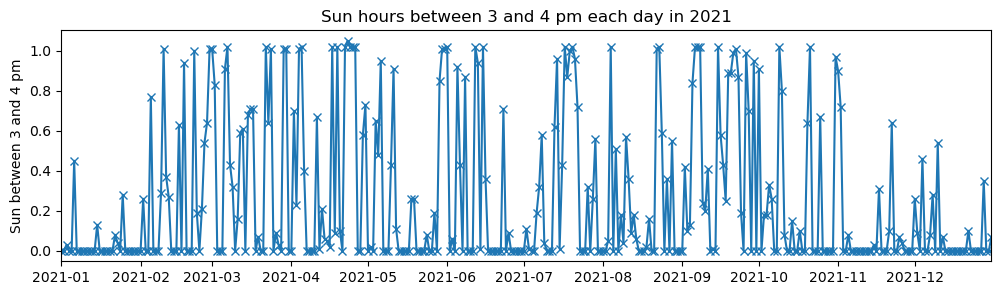

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
# plot daily sun hours
plt.plot(weather_station['date'], weather_station['total_sun_3to4pm'], '-x')
plt.title('Sun hours between 3 and 4 pm each day in 2021')
plt.ylabel('Sun between 3 and 4 pm')

# convert xaxis days to months
plt.xlim(weather_station['date'].min(), weather_station['date'].max())

plt.show()

#### 2.2. MODIS Images
You can download MODIS data directly from NASA's [EarthData](https://earthdata.nasa.gov) platform using the python package `earthaccess` (https://earthaccess.readthedocs.io/) as shown in the example below. After downloading, a variety of processing steps are required to get your satellite dataset machine learning-ready. For example, filtering out invalid or incomplete observations, remapping images onto a common grid, normalising each spectral channel, patching your dataset, etc.

For the purpose of this lab, we already downloaded and prepared a small MODIS dataset. Run the cells below to explore the data format and visualise what the images look like.

_______________
Example earthaccess download script:

```python
import earthaccess
auth_obj  = earthaccess.login('interactive')

results = earthaccess.search_data(
    # MOD = Terra, 02 = Level1B Radiances, 1KM  resolution (all 36 spectral bands)
    short_name= 'MOD021KM', 
    # (lon min, lat min, lon max, lat max) - Oxford: 51.75° N, 1.26° W
    bounding_box=(0.5, 51, 1.5, 52), 
    temporal=('2021-01-01', '2021-01-05'),
)

files = earthaccess.download(results, local_path='./')
```

In [32]:
import xarray as xr

MODIS_PATH = '../../../modis_challenge/modis_processed/'
sample_ds = xr.load_dataset(f'{MODIS_PATH}01/netcdf/MOD021KM.A2021002.1120.061.2021002190459_oxford_remap.nc')
sample_ds

<xarray.Dataset> Size: 4MB
Dimensions:  (y: 500, x: 500)
Coordinates:
  * y        (y) float64 4kB 54.99 54.98 54.97 54.96 ... 50.03 50.02 50.02 50.0
  * x        (x) float64 4kB -3.995 -3.985 -3.975 -3.965 ... 0.975 0.985 0.995
Data variables:
    3        (y, x) float32 1MB 6.089 7.228 7.228 7.788 ... 8.862 8.999 10.88
    1        (y, x) float32 1MB 4.054 5.109 5.109 5.204 ... 5.826 6.101 8.288
    5        (y, x) float32 1MB 3.88 3.438 3.438 2.39 ... 5.882 6.317 8.932
    2        (y, x) float32 1MB 7.385 7.159 7.159 6.036 ... 5.945 6.349 9.059
Attributes: (12/15)
    ancillary_variables:  []
    rows_per_scan:        10
    standard_name:        toa_bidirectional_reflectance
    modifiers:            []
    units:                %
    start_time:           2021-01-02 11:20:00
    ...                   ...
    reader:               modis_l1b
    area:                 Area ID: oxford_0.1x0.1_latlon_grid\nDescription: R...
    sensor:               modis
    calibration:          reflectance
    resolution:           1000
    platform_name:        EOS-Terra

As you can see, MODIS channels 1 to 5 were processed. Their specifications are shown in the table below.

![MODIS bands](./images/modis_bands.png)


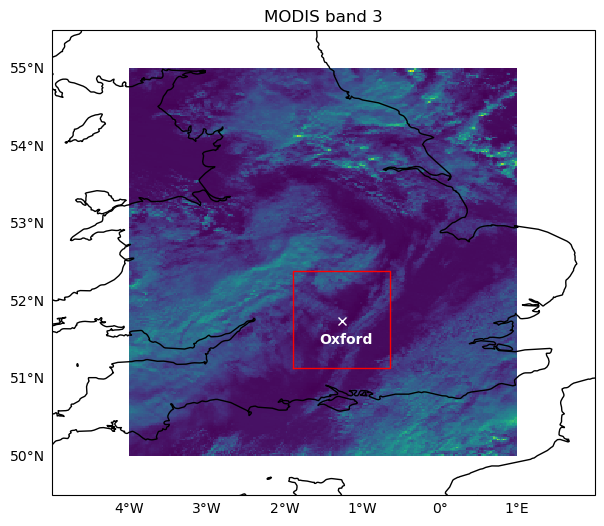

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

MODIS_PATH = '../../../modis_challenge/modis_processed/'

sample_ds = xr.load_dataset(f'{MODIS_PATH}01/netcdf/MOD021KM.A2021002.1120.061.2021002190459_oxford_remap.nc')

data = sample_ds['3']
patch = data.isel(x=slice(210,338,2), y=slice(260,388,2)) # Band 3


projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})

data.isel(x=slice(None,None,2), y=slice(None,None,2)).plot(ax=ax, transform=projection, cmap='viridis', add_colorbar=False)
ax.coastlines()
ax.set_extent([-5, 2, 49.5, 55.5], crs=projection)


# Add gridlines for reference
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0)
gl.top_labels = False
gl.right_labels = False


# add marker for Oxford
oxford_lon, oxford_lat = -1.2577, 51.7520
ax.plot(oxford_lon, oxford_lat, marker='x', color='white', markersize=6, label="Oxford", transform=projection)
ax.text(oxford_lon-0.3, oxford_lat-0.3, 'Oxford', color='white', weight='bold', fontsize=10)

# draw a rectangle around the area we are interested in
lons = [patch.x.min(), patch.x.max(), patch.x.max(), patch.x.min(), patch.x.min()]
lats = [patch.y.min(), patch.y.min(), patch.y.max(), patch.y.max(), patch.y.min()]
ax.plot(lons, lats, color='red', linewidth=1, transform=projection)

plt.title(f"MODIS band {data.name}")
plt.show()

**Question:** plot a few different MODIS images.

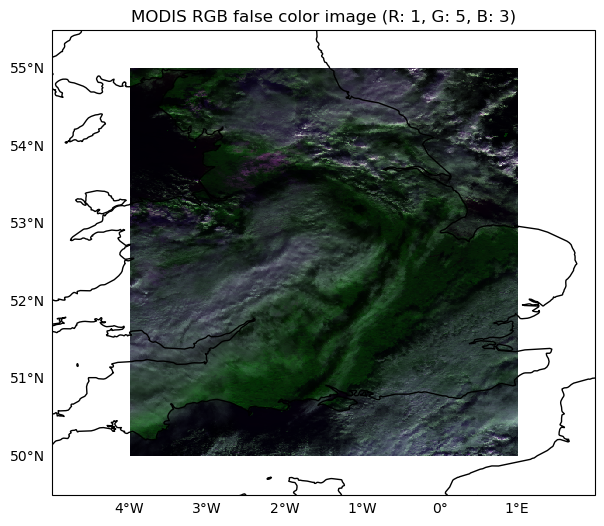

In [5]:
import numpy as np

def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

sample_ds = xr.load_dataset(f'{MODIS_PATH}01/netcdf/MOD021KM.A2021002.1120.061.2021002190459_oxford_remap.nc')

rgb_bands = ['1', '5', '3']

rgb = [sample_ds[var] for var in rgb_bands]
rgb = [da.fillna(np.nanmean(da)) for da in rgb]
rgb = [normalize(da) for da in rgb]
rgb = xr.concat(rgb, dim='band').transpose('y', 'x', 'band')

projection = ccrs.PlateCarree()

# plot the RGB false color image
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
rgb.plot.imshow(ax=ax)
ax.coastlines()
ax.set_extent([-5, 2, 49.5, 55.5], crs=projection)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0)
gl.top_labels = False
gl.right_labels = False

ax.set_title(f"MODIS RGB false color image (R: {rgb_bands[0]}, G: {rgb_bands[1]}, B: {rgb_bands[2]})")
plt.show()

### 3. Baseline
It's always a good idea to build a very simple model for the task we're trying to solve to get a performance baseline that we can compare more elaborate ML approaches to. For our baseline, we won't use MODIS images yet but explore how well a simple ML model - a Random Forest - can predict the amount of sun between 3 and 4pm using the amount of sun between 3 and 4 pm of the previous 3 days as input. This exercise enables us to think through a few crucial choices we need to make when developing our ML pipeline.

#### 3.1. Training and Test Dataset
First, we need to split our dataset into a training, validation and test set.

**Question:** How should we split our inputs? One option would be to use January to October for training our model, and to set aside November and December for validation and testing, respectively. Another option would be to use every other month for training, and split the other months into validation and test months. Will our choice affect model performance? Why (not)? Could we just create our input (preceding 3 days of sun observation) and output (amount of sun between 3 and 4pm) matrices and randomly choose 80% of entries for training and 20% for testing?

In [1]:
from utils import create_timeseries_dataset
import pandas as pd


def split_df_train_val_test(df: pd.DataFrame, 
                            train_months: list[int],
                            val_months: list[int],
                            test_months: list[int] ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into training and test sets based on a day of the month.

    Args:
    df: pd.DataFrame, the DataFrame to split
    day_split: int, the day of the month to split on (default is 23 which results in 82% training set, 18% test set)

    Returns:
    tuple, training set and test set DataFrames (df_train, df_test)
    """
    # df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df_train = df[df['month'].isin(train_months)]
    df_val = df[df['month'].isin(val_months)]
    df_test = df[df['month'].isin(test_months)]
    return df_train, df_val, df_test

# split the data into training and test sets
split_months = {
    'train': [1, 3, 5, 7, 9, 11],
    'val': [2, 6, 10],
    'test': [4, 8, 12]
}


weather_station = pd.read_csv('../../data/1-sunny-oxford/aopp-weatherstation/2021_measurements.csv')
weather_station['date'] = pd.to_datetime(weather_station['date'])


df_train, df_val, df_test = split_df_train_val_test(weather_station, 
                                                    train_months=split_months['train'],
                                                    val_months=split_months['val'],
                                                    test_months=split_months['test'])

# create input and output matrices for the training and test timeseries datasets
_, y_train, y_dates_train = create_timeseries_dataset(df_train, target_column='total_sun_per_day', inputs_length=3)
_, y_val, y_dates_val = create_timeseries_dataset(df_val, target_column='total_sun_per_day', inputs_length=3)
_, y_test, y_dates_test = create_timeseries_dataset(df_test, target_column='total_sun_per_day', inputs_length=3)

In [8]:
STATION_PATH = '../../data/1-sunny-oxford/ml-ready/weatherstation'
# read the datasets
X_train_df = pd.read_csv(f'{STATION_PATH}/train_df.csv')
X_val_df = pd.read_csv(f'{STATION_PATH}/val_df.csv')
X_test_df = pd.read_csv(f'{STATION_PATH}/test_df.csv')

# columns into numpy array
columns = X_train_df.keys()
columns = columns.drop('date')


X_train = X_train_df[columns].values
X_val = X_val_df[columns].values
X_test = X_test_df[columns].values

#### 3.2. Training our Random Forest
Now, it's time to train our first model! We'll use the `scikit-learn` (abbreviated as `sklearn`) implementation of a `RandomForestRegressor`, and assess model performance using mean squared error (MSE):

MSE $ = \frac{1}{n} \sum_{i=1}^{n}(Y_{i}-\hat{Y}_{i})^2$

($n = $ number of data points; $Y_{i}	=$ observed values; $\hat{Y}_{i}=$ predicted value)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# set the random seed for reproducibility
RANDOM_SEED = 42

# create and train the model
model = RandomForestRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# calculate the mean squared error
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_val = root_mean_squared_error(y_val, y_pred_val)

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Validation RMSE: {rmse_val:.4f}')

Training RMSE: 1.1695
Validation RMSE: 3.7752


**Question:** The Random Forest seems to be overfitting to the training dataset (how do we know this?). We don't expect great model performance, but this seems quite severe. Read the documentation of the [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Are there any parameters which could improve this issue? Choose 1 or 2 hyperparameters and test whether you can improve validation performance by changing its value.

In [28]:
# create and train the model
model = RandomForestRegressor(max_depth=3, min_samples_split=3, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# calculate the mean squared error
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_val = root_mean_squared_error(y_val, y_pred_val)

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Validation RMSE: {rmse_val:.4f}')

Training RMSE: 2.3786
Validation RMSE: 3.7339


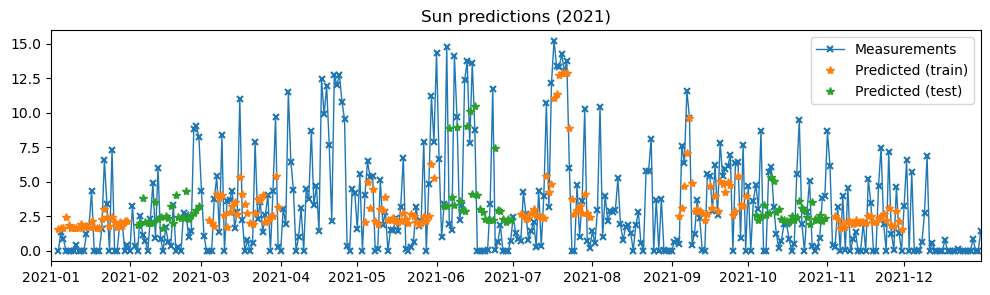

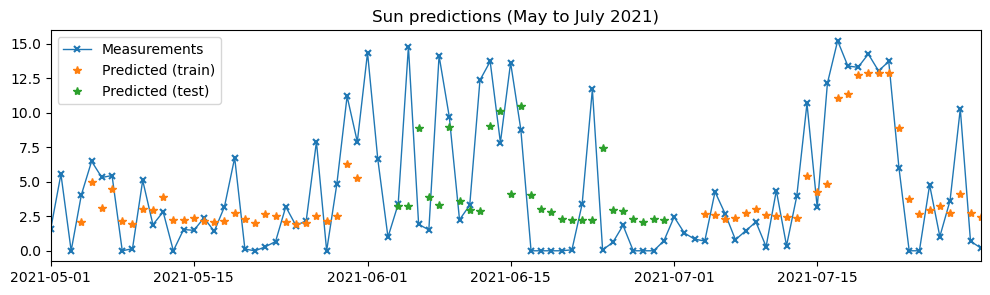

In [33]:
from utils import plot_time_series_predictions

plot_time_series_predictions(
    y_true=weather_station['total_sun_per_day'][3:],
    y_dates=weather_station['date'][3:],
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_val,
    y_dates_train=y_dates_train,
    y_dates_test=y_dates_val,
    xlim=(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-31'))
)

plt.title('Sun predictions (2021)')
plt.show()

plot_time_series_predictions(
    y_true=weather_station['total_sun_per_day'][3:],
    y_dates=weather_station['date'][3:],
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_val,
    y_dates_train=y_dates_train,
    y_dates_test=y_dates_val,
    xlim=(pd.Timestamp('2021-05-01'), pd.Timestamp('2021-07-31'))
)

plt.title('Sun predictions (May to July 2021)')
plt.show()

#### 3.3. Metrics

**TODO ADD METRICS TEXT**

**Question:**  
Plot the actual vs. predicted values in a scatterplot, and compute the R^2 Score on the training and validation datasets. How well do predictions follow the observed values? What do you notice about the predictions of the RandomForest?

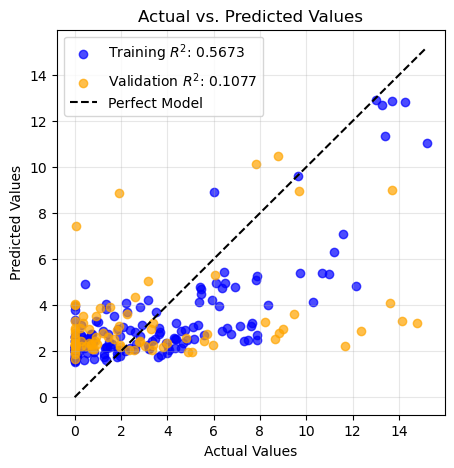

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# calculate the R^2 score
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

# print(f'Training R^2: {r2_train:.4f}')
# print(f'Validation R^2: {r2_val:.4f}')

# Scatter plot
plt.figure(figsize=(5, 5))

# Training scatter
plt.scatter(y_train, y_pred_train, color='blue', label=rf'Training $R^2$: {r2_train:.4f}', alpha=0.7)
# Validation scatter
plt.scatter(y_val, y_pred_val, color='orange', label=rf'Validation $R^2$: {r2_val:.4f}', alpha=0.7)

# Reference line (y = x)
max_val = max(max(y_train), max(y_val), max(y_pred_train), max(y_pred_val))
min_val = min(min(y_train), min(y_val), min(y_pred_train), min(y_pred_val))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='Perfect Model')

# Plot formatting
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

As we can see, our baseline shows minimal predictive skill on the validation set, and is far from being a perfect model. Let's try and improve predictions by exploiting our satellite dataset.

### 4. Model Development
Now that we've explored our data and trained a first baseline model, we will develop our `pytorch lightning`(https://lightning.ai/docs/pytorch/stable/) training pipeline that integrates MODIS observations. Our pipeline will consist of a dataloader, model, trainer, and evaluation metrics. 


In [100]:
import numpy as np
import torch
from torch.utils.data import Dataset
from datetime import datetime

# helper function to extract the date from a MODIS filename
def get_date_from_modis_filename(filename: str) -> datetime:
    return datetime.strptime(filename.split("/")[-1][9:22], "A%Y%j.%H%M")

class SunnyOxfordDataset(Dataset):   
    # helper function to match a MODIS image with an AOPP observation
    def _match_aopp_observation(self, modis_filename: str) -> dict:
        modis_date = get_date_from_modis_filename(modis_filename)
        # print(f'modis date: {modis_date.date()} and type: {type(modis_date.date())}')
        # print(f'aopp date: {self.aopp_dataframe["date"].dt.date[0]} and type: {type(self.aopp_dataframe["date"].dt.date[0])}')
        
        aopp_row = self.aopp_dataframe[self.aopp_dataframe["date"].dt.date == modis_date.date()]
        if len(aopp_row) == 0:
            print(f"No AOPP observation found for {modis_date}")
            return None
        else:
            return aopp_row.to_dict(orient="records")[0]
        
    def __init__(
        self,
        modis_filenames: list[str],
        aopp_dataframe: pd.DataFrame,
        station_inputs: list[str],
        bands: list[str] = ['1'],
        means: list[float] | None = None,
        stds: list[float] | None = None,
        
    ):
        self.modis_filenames = modis_filenames
        self.aopp_dataframe = aopp_dataframe
        self.station_inputs = station_inputs
        self.bands = bands
        if means is not None:
            assert len(means) == len(bands) and len(stds) == len(bands), "Means, stds and bands must have the same length"
        self.means = means
        self.stds = stds


    def __getitem__(self, ind) -> np.ndarray:
        item = {}
        ds = xr.load_dataset(self.modis_filenames[ind])

        # select the bands to keep
        if self.bands is not None:
            x = np.array([ds[band].values for band in self.bands])
        else:
            x = np.array([ds[band].values for band in list(ds.var())])
        # normalise each band of the input image
        if self.means is not None and self.stds is not None:
            for i in range(x.shape[0]):
                x[i, :, :] = (x[i, :, :] - self.means[i]) / self.stds[i]

        # fill NaN values in each band with the mean of the non-NaN values of that band
        for i in range(x.shape[0]):
            if np.isnan(np.nanmean(x[i, :, :])):
                print(f'all nan for file {self.modis_filenames[ind]}')
            x[i, :, :] = np.nan_to_num(x[i, :, :], nan=np.nanmean(x[i, :, :]))

        # convert to tensor
        x = torch.as_tensor(x, dtype=torch.float32)

        item["modis_image"] = x
        
        for key, value in self._match_aopp_observation(self.modis_filenames[ind]).items():
            if key in self.station_inputs:
                item[key] = torch.as_tensor(value, dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.modis_filenames)

In [101]:
import glob
modis_filenames = glob.glob(MODIS_PATH + "/**/*.nc", recursive=True)
modis_filenames = sorted(modis_filenames)
y_dates_aopp = weather_station['date']

In [97]:
from lightning import LightningDataModule
from torch.utils.data import DataLoader
import glob

class SunnyOxfordDatamodule(LightningDataModule):
    def _split_modis_files(self, modis_filenames: list[str], months: list[int]) -> list[str]:
        return [f for f in modis_filenames if get_date_from_modis_filename(f).month in months]

    def __init__(
        self,
        data_dir: str,
        split_months: dict,
        station_dfs: dict,
        bands: list[str] = ['1'],
        station_inputs: list[str] = ['total_sun_per_day'],
        batch_size: int = 4,
        means: list[float] = None,
        stds: list[float] = None,
    
    ):
        super().__init__()

        self.data_dir = data_dir
        self.modis_filenames = glob.glob(self.data_dir + "/**/*.nc", recursive=True)
        self.split_months = split_months
        self.station_dfs = station_dfs
        self.bands = bands
        self.station_inputs = station_inputs

        self.batch_size = batch_size

        self.means = means
        self.stds = stds

        # split filenames based on train/test/val criteria
        train_modis_files = self._split_modis_files(self.modis_filenames, split_months['train'])
        val_modis_files = self._split_modis_files(self.modis_filenames, split_months['validation'])
        test_modis_files = self._split_modis_files(self.modis_filenames, split_months['test'])
        
        self.train_dataset = SunnyOxfordDataset(
            modis_filenames=train_modis_files,
            aopp_dataframe=self.station_dfs['train'],
            bands=self.bands,
            means=self.means,
            stds=self.stds,
            station_inputs=self.station_inputs
        )

        self.val_dataset = SunnyOxfordDataset(
            modis_filenames=val_modis_files,
            aopp_dataframe=self.station_dfs['validation'],
            bands=self.bands,
            means=self.means,
            stds=self.stds,
            station_inputs=self.station_inputs
        )

        self.test_dataset = SunnyOxfordDataset(
            modis_filenames=test_modis_files,
            aopp_dataframe=self.station_dfs['test'],
            bands=self.bands,
            means=self.means,
            stds=self.stds,
            station_inputs=self.station_inputs
        )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [43]:
import pandas as pd

split_months = {
    'train': [1, 3, 5, 7, 9, 11],
    'validation': [2, 6, 10],
    'test': [4, 8, 12]
}

STATION_PATH = '../../data/1-sunny-oxford/ml-ready/weatherstation'
# read the datasets
X_train_df = pd.read_csv(f'{STATION_PATH}/train_df.csv')
X_val_df = pd.read_csv(f'{STATION_PATH}/val_df.csv')
X_test_df = pd.read_csv(f'{STATION_PATH}/test_df.csv')


station_dfs = {
    'train': df_train,
    'validation': df_val,
    'test': df_test
}


datamodule = SunnyOxfordDatamodule(
    data_dir=MODIS_PATH,
    split_months=split_months,
    station_dfs=station_dfs,
    bands=['1'],
    station_inputs=columns,
    batch_size=4
)

data = next(iter(datamodule.train_dataloader()))
data.keys()

No AOPP observation found for 2021-05-04 10:15:00
No AOPP observation found for 2021-01-16 11:30:00
No AOPP observation found for 2021-07-06 11:10:00


/tmp/ipykernel_3675872/4185375847.py:54: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(x[i, :, :])):


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:
data = next(iter(datamodule.train_dataloader()))
data.keys()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [13]:
columns = ['date', 'time', 'filename', 'path']
modis_images = pd.read_csv('../../data/1-sunny-oxford/modis/valid_granules_for_training.csv')[columns]
# modis_images['date'] = pd.to_datetime(modis_images['date'])
modis_images.head()

,date,time,filename,path
0,2021-01-02,11:20:00,MOD021KM.A2021002.1120.061.2021002190459.hdf,2021/01/02/MOD021KM.A2021002.1120.061.20210021...
1,2021-01-04,11:05:00,MOD021KM.A2021004.1105.061.2021004190923.hdf,2021/01/04/MOD021KM.A2021004.1105.061.20210041...
2,2021-01-10,10:30:00,MOD021KM.A2021010.1030.061.2021010190550.hdf,2021/01/10/MOD021KM.A2021010.1030.061.20210101...
3,2021-01-13,11:00:00,MOD021KM.A2021013.1100.061.2021013191123.hdf,2021/01/13/MOD021KM.A2021013.1100.061.20210131...
4,2021-01-15,10:50:00,MOD021KM.A2021015.1050.061.2021015191617.hdf,2021/01/15/MOD021KM.A2021015.1050.061.20210151...


In [11]:
# input: morning satellite image (9-12 am)
# output: predicted sun hours for the day

### X. Interpretability - the Importance of Environmental Inputs
**The model clearly outperforms our simple baseline - but is this as good as it gets?** In this part of the lab, we will explore whether the model benefits from receiving additional weather station measurements as input, and we will try to gain some insight into how important the different inputs are for predicting sunnyness using *Feature Importance*.

In [4]:
# input image + wind
# 3 day sun hours + temperature + wind
# study feature importance

### X. Predictability of Weather and Climate
By now, we have created a model that can predict sunnyness a few hours ahead fairly well. But how does model performance change when we try to predict sunnyness a day, two days, a week ahead?